In [2]:
import torch
import random
import cv2
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
from dataset import *


In [4]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

IMAGE_DATA  = "./data/test_images"
MASK_DATA   = "./data/test_masks"
CSV_FILE    = "./data/sample_submission.csv"
CAM_MTX     = [1,1,1,1]
CAR_MODELS  = "./data/car_models"

In [15]:
Mask_rCNN   = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
Mask_rCNN.eval()
Dataset     = AutonomousDrivingDataset(IMAGE_DATA, MASK_DATA, CSV_FILE, CAM_MTX, CAR_MODELS, transform=[transforms.ToTensor()])

def get_prediction(img, threshold, model):
  pred = model([img])
  pred_score = list(pred[0]['scores'].detach().numpy())
  pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
  masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
  pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
  pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().numpy())]
  masks = masks[:pred_t+1]
  pred_boxes = pred_boxes[:pred_t+1]
  pred_class = pred_class[:pred_t+1]
  return masks, pred_boxes, pred_class

def random_colour_masks(image):
  colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r, g, b], axis=2)
  return coloured_mask

def instance_segmentation(img, model, threshold=0.5, rect_th=3, text_size=3, text_th=3):
  masks, boxes, pred_cls = get_prediction(img, threshold, model)
  trf   = T.ToPILImage()
  img   = trf(img)
  img.save("./tmp.png")
  img   = cv2.imread("./tmp.png")
  img   = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  for i in range(len(masks)):
    rgb_mask = random_colour_masks(masks[i])
    img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
    plt.imshow(img)
    print(boxes[i])
    cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    cv2.putText(img,pred_cls[i], boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
  plt.figure(figsize=(20,30))
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  plt.show()

[(813, 1713), (1014, 1859)]
[(0, 1741), (429, 2291)]
[(692, 2356), (2363, 2685)]
[(392, 1635), (527, 1695)]
[(644, 1658), (708, 1711)]
[(1134, 1651), (1249, 1741)]
[(1203, 1685), (1257, 1738)]
[(2781, 1914), (2975, 2058)]
[(1010, 1672), (1088, 1722)]
[(1133, 1682), (1199, 1740)]
[(1180, 1664), (1256, 1741)]


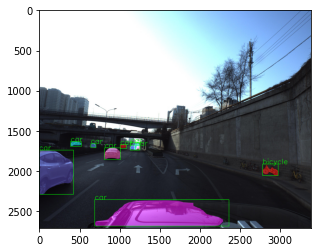

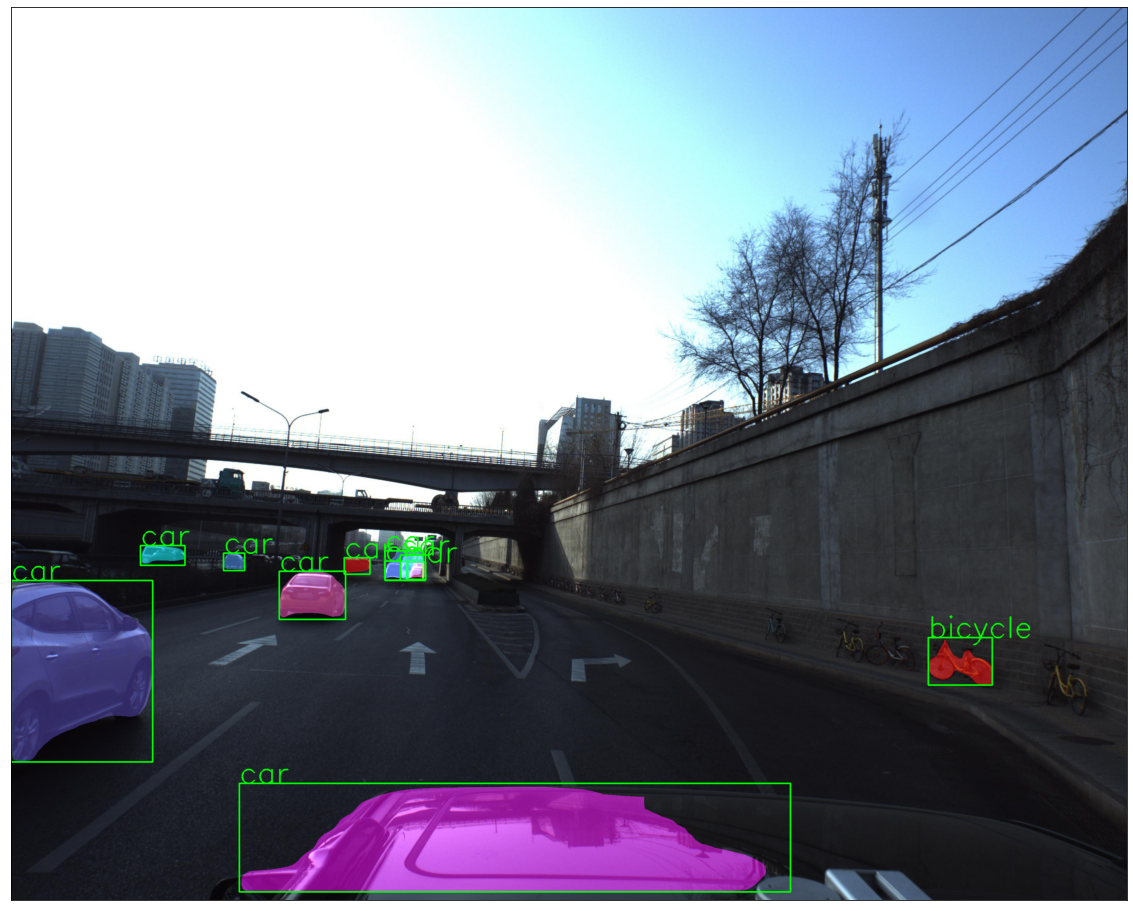

In [16]:
X, y    = Dataset.__getitem__(1)

instance_segmentation(X, Mask_rCNN)